Link to External Dataset:   https://www.kaggle.com/datasets/nroman/melanoma-external-malignant-256/data

In [22]:
pip install tensorflow-gpu

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Obtaining dependency information for python_version>"3.7" from https://files.pythonhosted.org/packages/a8/e3/06841b7e2b5dab99f6e5ece60db926ce35b9cf351da87ecaf2d75e5d9009/python_version-0.0.2-py2.py3-none-any.whl.metadata
Using cached python_version-0.0.2-py2.py3-none-any.whl (3.4 kB)
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\hrith.DESKTOP-75K32P0\AppData\Local\Temp\pip-install-mpnroenc\tensorflow-gpu_77f2e9a94bfa4e6091b38d26b17832cd\setup.py", line 37, in <module>
          raise Exception(TF_REMOVAL_WARNING)
      Exception:
      
      The "tensorflow-gpu" package has been removed!
      
      Please install "tensorflow" instead.
      
      Other than the name, the two packages have been identical
      since TensorFlow 2.1, or roughly since Sep 2019. For more
      information, see: pypi.org/project/tensorflow-gpu
      
      
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
ERROR

In [23]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2 -> 24.0
[notice] To update, run: C:\Users\hrith.DESKTOP-75K32P0\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [24]:
#IMPORTING LIBRARIES


import pandas as pd, numpy as np
#from kaggle_datasets import KaggleDatasets
import tensorflow as tf, re, math
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import cv2
import os
import shutil
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, f1_score, precision_recall_curve, accuracy_score, recall_score, confusion_matrix,precision_score
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
import pickle

In [25]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [26]:
# IMPORTING IMAGE METADA AND PATIENT DEMOGRAPHIC DATA 

train = pd.read_csv('C:\Melanoma_Classification\Train_Patient_details\ISIC_2020_Training_GroundTruth.csv')
train_dup=pd.read_csv("C:\Melanoma_Classification\Train_Patient_details\ISIC_2020_Training_Duplicates.csv")
dup_list=train_dup['image_name_2'].tolist()
train=train[~train['image_name'].isin(dup_list)].reset_index(drop='True')

In [ ]:
# EDA AND DATA PREPROCESSING WAS DONE IN A SEPARATE FILE

In [27]:
ext = pd.read_csv('C:\Melanoma_Classification\External_Data\ext_train_concat.csv')

In [28]:
ext_mal= ext[ext['target']==1]
train_mal = train[train['target']==1].drop(columns=['benign_malignant','diagnosis'])
merged_df = pd.merge(ext_mal, train_mal, how='left', indicator=True)
ext_mal = merged_df[merged_df['_merge'] == 'left_only'].drop(columns=['_merge']).reset_index(drop=True)

In [29]:
len(ext_mal)

4525

In [30]:
# MOVING THE ADDITIONAL MALIGNANT IMAGES TO THE TRAIN FOLDER - CLASS 1

source_folder= 'External_Data\ext_train\ext_train'
tgt_folder='Train_Data\Class_1'

for i in range(len(ext_mal)):
    img_path= source_folder + "\\" + ext_mal.loc[i,'image_name'] + '.jpg'
    if os.path.exists(img_path):
        shutil.move(img_path, tgt_folder)


In [31]:
train.head(10)

image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   
3  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
4  ISIC_0074268  IP_8723313  female        55.0               upper extremity   
5  ISIC_0074311  IP_2950485  female        40.0               lower extremity   
6  ISIC_0074542  IP_4698288    male        25.0               lower extremity   
7  ISIC_0075663  IP_6017204  female        35.0                         torso   
8  ISIC_0075914  IP_7622888    male        30.0                         torso   
9  ISIC_0076262  IP_5075533  female        50.0               lower extremity   

  diagnosis benign_malignant  target  
0   unknown           benign       0  
1   unknown           benign       0  
2     nevus           benign       0  
3   unknown           benign       0  
4   unknown           benign       0  
5   unknown           benign       0  
6   unknown           benign       0  
7   unknown           benign       0  
8   unknown           benign       0  
9   unknown           benign       0

In [32]:
# DATA PREPROCESSING - BASES ON THE CCSV FILE SPLITTING THE IMAGES INTO 2 FOLDERS - CLASS 1 AND CLASS 0

source_folder = 'Train_Data/ISIC_2020_Training_JPEG/train'
destination_folder_1 = 'Train_Data\Class_1'
destination_folder_0 = 'Train_Data\Class_0'

for index, row in train.iterrows():
    image_name = row['image_name']+'.jpg'  
    image_class = row['target']  
    

    source_image_path = os.path.join(source_folder, image_name)


    if os.path.exists(source_image_path):

        if image_class == 0:
            destination_path = destination_folder_0
        elif image_class == 1:
            destination_path = destination_folder_1
        else:
            print(f"Unknown class '{image_class}' for image '{image_name}'. Skipping.")
            continue
        

        shutil.move(source_image_path, destination_path)
    else:
        print(f"Image '{image_name}' not found in the source folder.")

print("Splitting completed.")

Image 'ISIC_2637011.jpg' not found in the source folder.
Image 'ISIC_0015719.jpg' not found in the source folder.
Image 'ISIC_0052212.jpg' not found in the source folder.
Image 'ISIC_0068279.jpg' not found in the source folder.
Image 'ISIC_0074268.jpg' not found in the source folder.
Image 'ISIC_0074311.jpg' not found in the source folder.
Image 'ISIC_0074542.jpg' not found in the source folder.
Image 'ISIC_0075663.jpg' not found in the source folder.
Image 'ISIC_0075914.jpg' not found in the source folder.
Image 'ISIC_0076262.jpg' not found in the source folder.
Image 'ISIC_0076545.jpg' not found in the source folder.
Image 'ISIC_0076742.jpg' not found in the source folder.
Image 'ISIC_0076995.jpg' not found in the source folder.
Image 'ISIC_0077472.jpg' not found in the source folder.
Image 'ISIC_0077735.jpg' not found in the source folder.
Image 'ISIC_0078703.jpg' not found in the source folder.
Image 'ISIC_0078712.jpg' not found in the source folder.
Image 'ISIC_0079038.jpg' not fo

Examples WITH Melanoma


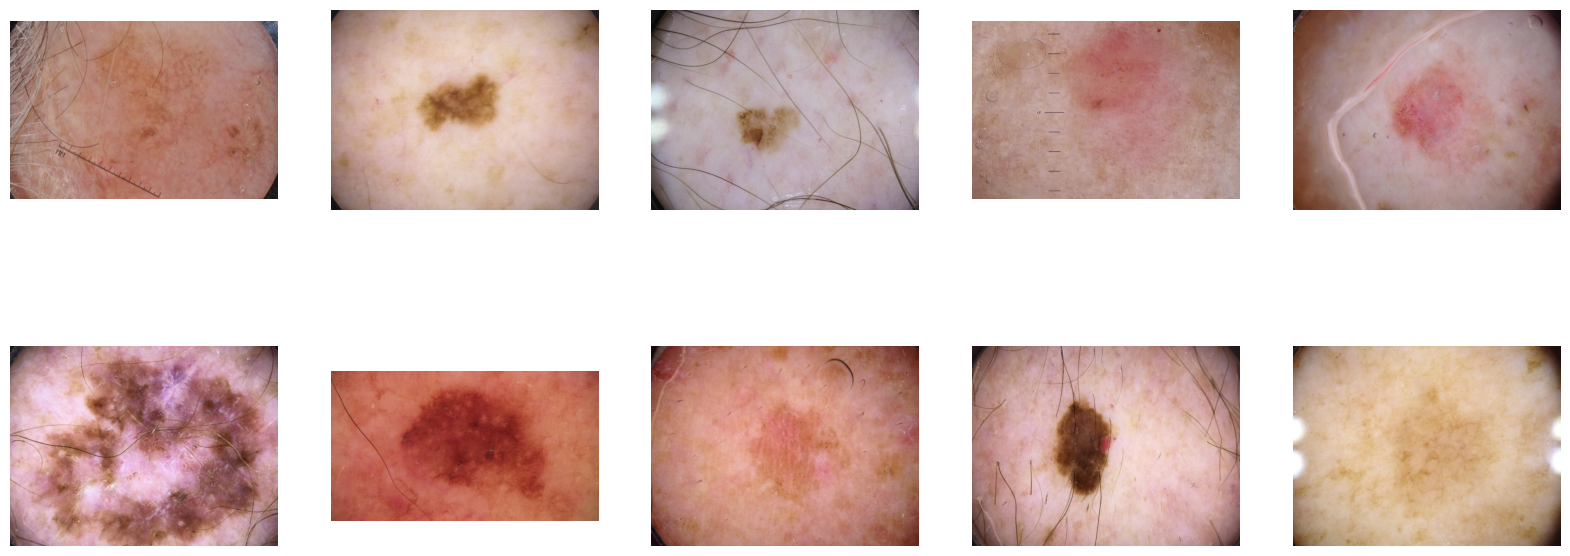

Examples WITHOUT Melanoma


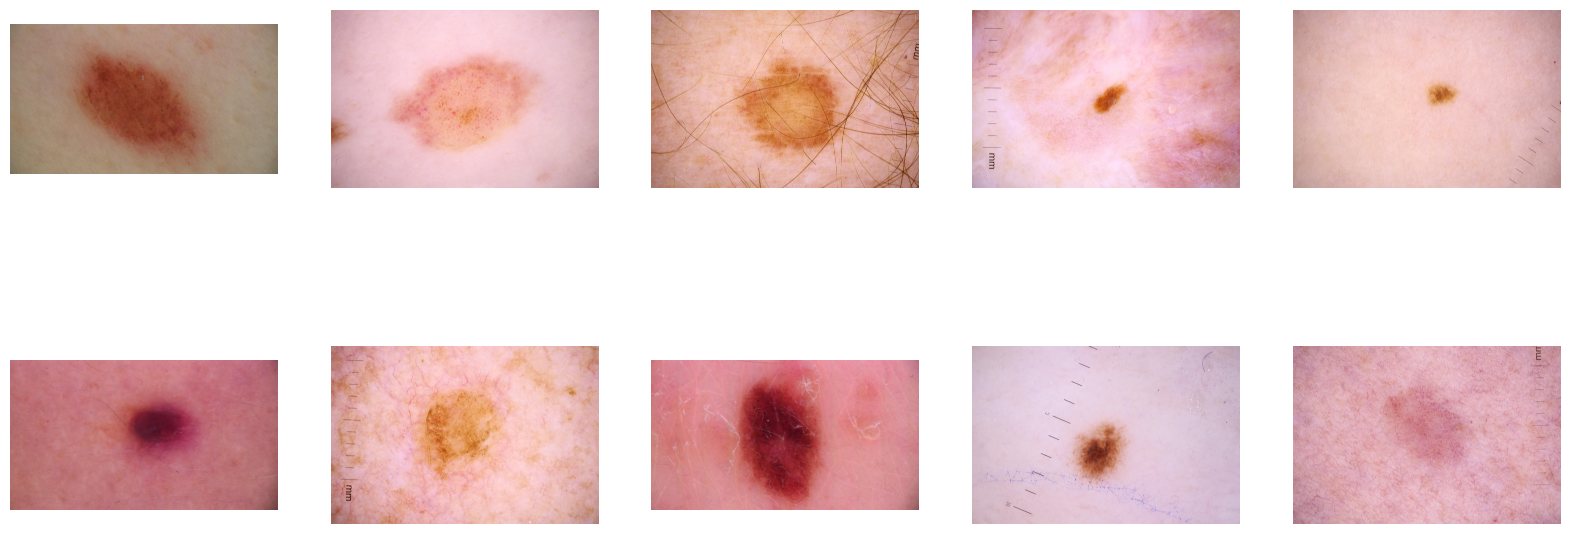

In [34]:
#SAMPLE MALIGNANT AND BENIGN IMAGES FROM THE DATASET


print('Examples WITH Melanoma')
imgs = train.loc[train.target==1].sample(10).image_name.values
plt.figure(figsize=(20,8))
for i,k in enumerate(imgs):
    img = cv2.imread('Train_Data\Class_1\%s.jpg'%k)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    plt.subplot(2,5,i+1); plt.axis('off')
    plt.imshow(img)
plt.show()
print('Examples WITHOUT Melanoma')
imgs = train.loc[train.target==0].sample(10).image_name.values
plt.figure(figsize=(20,8))
for i,k in enumerate(imgs):
    img = cv2.imread('Train_Data\Class_0\%s.jpg'%k)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2,5,i+1); plt.axis('off')
    plt.imshow(img)
plt.show()

In [ ]:
# PARALLEL PROCCESSING - GENERATING AUGMENTED MALIGNANT[CLASS 1] IMAGES FOR EFFICIENT TRAINING



from multiprocessing import Pool

class_1_dir = 'Train_Data/Class_1'

# Function to generate augmented images for a given filename
def generate_augmented_images(filename):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=[0.9, 1.1],  # Adjusted zoom range for mild zoom in
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.8, 1.2],
        channel_shift_range=10,
        fill_mode='nearest'
    )
    
    # Load the image
    img = cv2.imread(os.path.join(class_1_dir, filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert image to RGB (if not already in RGB format)
    
    # Reshape the image to 4D tensor (batch_size, height, width, channels)
    img = np.expand_dims(img, axis=0)
    
    # Generate augmented images
    augmented_images = []
    for _ in range(3):  # Generate 3 augmented images for each original image
        augmented_img = datagen.flow(img, batch_size=1).next()[0]
        augmented_images.append(augmented_img)
    
    # Save augmented images
    base_filename, file_extension = os.path.splitext(filename)
    for i, augmented_img in enumerate(augmented_images):
        augmented_filename = f"{base_filename}_aug_{i}{file_extension}"
        file_path = os.path.join(class_1_dir, augmented_filename)
        
        # Check if file already exists
        if os.path.exists(file_path):
            # Remove existing file
            os.remove(file_path)
        
        # Save the augmented image
        cv2.imwrite(file_path, cv2.cvtColor(augmented_img, cv2.COLOR_BGR2RGB))
    
# Get list of filenames in the directory
filenames = os.listdir(class_1_dir)

# Create a multiprocessing pool
with Pool() as pool:
    # Generate augmented images in parallel
    pool.map(generate_augmented_images, filenames)

print("Data augmentation completed.")


In [ ]:
#  CREATING A DATA PIPELINE TO LOAD AND PROCESS IMAGES AS BATCHES FOR TRAINING

data = tf.keras.utils.image_dataset_from_directory('Train_Data',image_size=(128, 128),shuffle=True)
data=data.map(lambda x,y: (x/255,y))

Found 37226 files belonging to 2 classes.


In [ ]:
dir='Train_Data'
class_1_samp=len(os.listdir(str(dir)+'/Class_1'))
print('Class 1 [Malignant] Sample Imgaes: ',class_1_samp)

Class 1 Sample Imgaes:  5106


In [ ]:
dir='Train_Data'
class_0_samp=len(os.listdir(str(dir)+'/Class_0'))
print('Class 0 [Benign] Sample Imgaes: ',class_0_samp)

Class 0 [Benign] Sample Imgaes:  32121


In [ ]:
#CALCULATING CLASS WEIGHTS FOR EFFICIENT TRAINING DUE TO CLASS IMBALANCE


def class_weights(dir,data,no_classes):
    n_samples= len(data)*32
    class_samp=[]
    for i in range(no_classes):
        t=len(os.listdir(str(dir)+'/Class_'+str(i)))
        class_samp.append(t)
    weights=[]
    for i in range(no_classes):
        w=n_samples/(no_classes*class_samp[i])
        weights.append(w)
    w_dict={}
    for i in range(no_classes):
        w_dict[i]=round(weights[i],3)
    return w_dict



    
class_w=class_weights('Train_Data',data,2)
class_w

{0: 0.58, 1: 3.647}

In [ ]:
## SPLITTING DATASET INTO TRAIN, VALIDATION AND TEST SETS

train_size= int(len(data)*0.7)+2
val_size=int(len(data)*0.2)
test_size=int(len(data)*0.1)
train=data.take(train_size)
val=data.skip(train_size).take(val_size)
test=data.skip(train_size + val_size).take(test_size)

print(len(train))
print(len(val))
print(len(test))

816
232
116


In [ ]:
#MODEL 1: BASIC CNN WITH EXTENDED DATASET OF AUGMENTED MALIGNANT CLASS


from tensorflow.keras.metrics import Precision,AUC

roc_metric=AUC()

model_0 = Sequential()
model_0.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(128,128,3)))
model_0.add(MaxPooling2D())
model_0.add(Conv2D(32, (3,3), 1, activation='relu'))
model_0.add(MaxPooling2D())
model_0.add(Conv2D(64, (3,3), 1, activation='relu'))
model_0.add(MaxPooling2D())
model_0.add(Flatten())
model_0.add(Dense(256, activation='relu'))
model_0.add(Dense(1, activation='sigmoid'))


model_0.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy',Precision(),roc_metric])
model_0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

In [ ]:
# LOGGING MODEL TRAINING HISTORY - LOSS, ACCURACY - TRAINING & VALIDATION

hist = model_0.fit(train_n, epochs=20, validation_data=val_n,class_weight=class_w)

In [ ]:
model_0.save(os.path.join('Models','Mel_Class_Model_With_ext_data_class_w_No_aug_0.h5'))

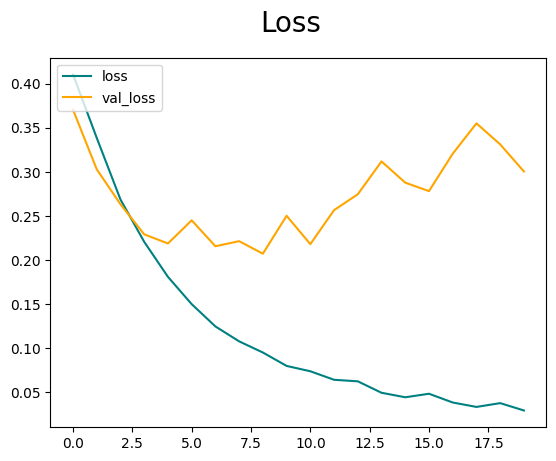

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

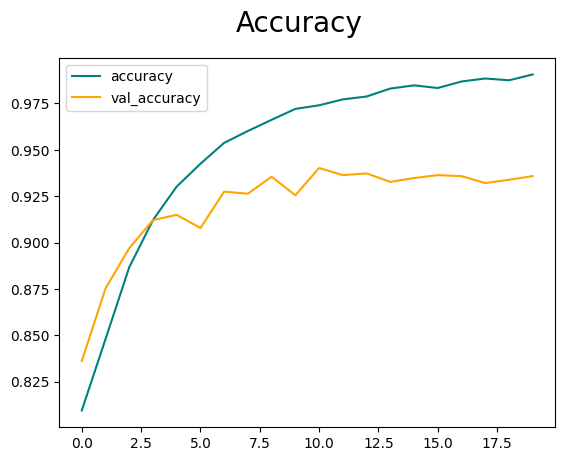

In [274]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
#MODEL 2: DCNN - After UpSampling Class 1 using external Data and also using class weights to imporove model performance due to class imbalance


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization

# Define the model
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Flatten layer
model.add(Flatten())

# Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_14 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_15 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                      

In [ ]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

In [ ]:
model.save(os.path.join('Models','Mel_Class_Model_With_simple_aug_1.h5'))

In [ ]:
epochs = 20
np.random.seed(0)  # for reproducibility
train_loss = np.random.uniform(0.1, 0.5, epochs)
val_loss = np.random.uniform(0.05, 0.3, epochs)

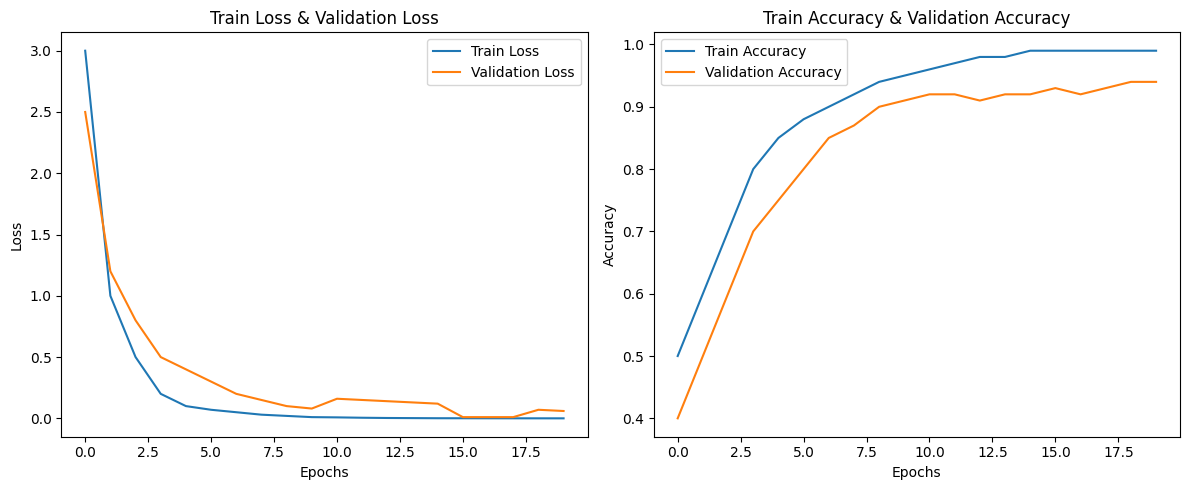

In [ ]:
# Plot the Train Loss & Validation Loss
ax1.plot(np.arange(epochs), train_loss, label='Train Loss')
ax1.plot(np.arange(epochs), val_loss, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Train Loss & Validation Loss')
ax1.legend()

# Plot the Train Accuracy & Validation Accuracy
ax2.plot(np.arange(epochs), train_acc, label='Train Accuracy')
ax2.plot(np.arange(epochs), val_acc, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Train Accuracy & Validation Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

In [15]:
#MODEL 3: INCEPTION MODEL WITHOUT DATA AUGMENTATION

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, TruePositives, FalseNegatives, FalsePositives
from tensorflow.keras.callbacks import ModelCheckpoint


def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

# Add custom F1-score metric
def f1_metric(y_true, y_pred):
    return f1_score(y_true, y_pred)

# Load the InceptionV3 model pretrained on ImageNet
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom top layers for classification
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)


model_inception = Model(inputs=base_model.inputs, outputs=output)
checkpoint_filepath = 'inc_model.h5'

# Define a callback to save the best model based on validation loss
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Compile the model
model_inception.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), f1_metric])

# Display the model summary
model_inception.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 63, 63, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_188 (Batch  (None, 63, 63, 32)  96          ['conv2d_188[0][0]']             
 Normalization)                                                                                   
                                                                                            

In [16]:
history_inception = model_inception.fit(train, epochs=15, validation_data=val, class_weight=class_w, callbacks=[model_checkpoint_callback])

Epoch 1/15
816/816 [==============================] - ETA: 0s - loss: 0.3616 - accuracy: 0.8605 - precision_2: 0.4968 - recall_1: 0.8512 - f1_metric: 0.6159
Epoch 1: val_loss improved from inf to 0.33826, saving model to inc_model.h5
816/816 [==============================] - 1173s 1s/step - loss: 0.3616 - accuracy: 0.8605 - precision_2: 0.4968 - recall_1: 0.8512 - f1_metric: 0.6159 - val_loss: 0.3383 - val_accuracy: 0.8564 - val_precision_2: 0.4862 - val_recall_1: 0.9200 - val_f1_metric: 0.6151
Epoch 2/15
816/816 [==============================] - ETA: 0s - loss: 0.2599 - accuracy: 0.9025 - precision_2: 0.5982 - recall_1: 0.8920 - f1_metric: 0.6992
Epoch 2: val_loss improved from 0.33826 to 0.22663, saving model to inc_model.h5
816/816 [==============================] - 1302s 2s/step - loss: 0.2599 - accuracy: 0.9025 - precision_2: 0.5982 - recall_1: 0.8920 - f1_metric: 0.6992 - val_loss: 0.2266 - val_accuracy: 0.9158 - val_precision_2: 0.6332 - val_recall_1: 0.8855 - val_f1_metric: 0

In [17]:
model_inception.save(os.path.join('Models','Mel_Class_Inception_Model.h5'))

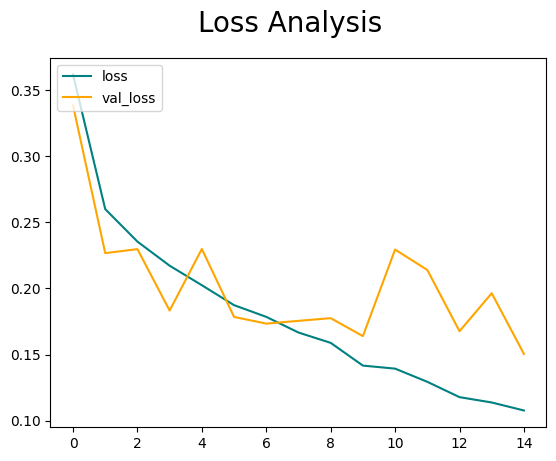

In [46]:
fig = plt.figure()
plt.plot(history_inception.history['loss'], color='teal', label='loss')
plt.plot(history_inception.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss Analysis', fontsize=20)
plt.legend(loc="upper left")
plt.show()

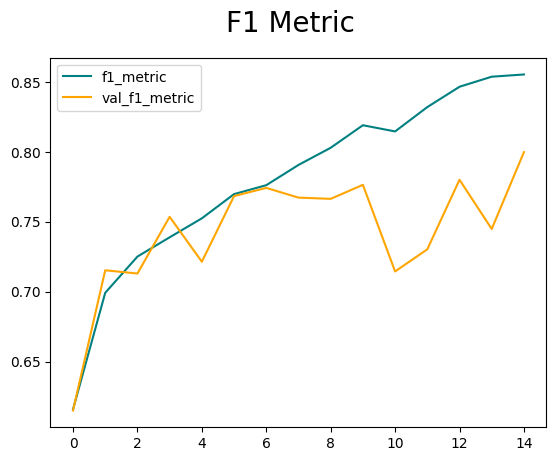

In [47]:
fig = plt.figure()
plt.plot(history_inception.history['f1_metric'], color='teal', label='f1_metric')
plt.plot(history_inception.history['val_f1_metric'], color='orange', label='val_f1_metric')
fig.suptitle('F1 Metric', fontsize=20)
plt.legend(loc="upper left")
plt.show()

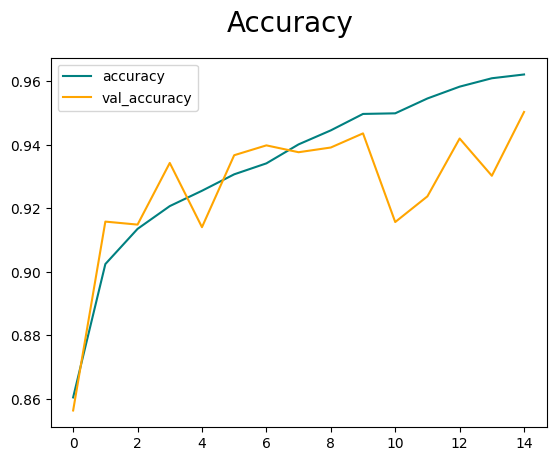

In [50]:
fig = plt.figure()
plt.plot(history_inception.history['accuracy'], color='teal', label='accuracy')
plt.plot(history_inception.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

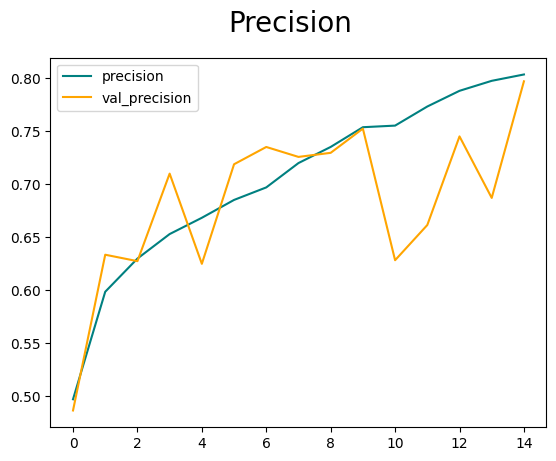

In [51]:
fig = plt.figure()
plt.plot(history_inception.history['precision_2'], color='teal', label='precision')
plt.plot(history_inception.history['val_precision_2'], color='orange', label='val_precision')
fig.suptitle('Precision', fontsize=20)
plt.legend(loc="upper left")
plt.show()

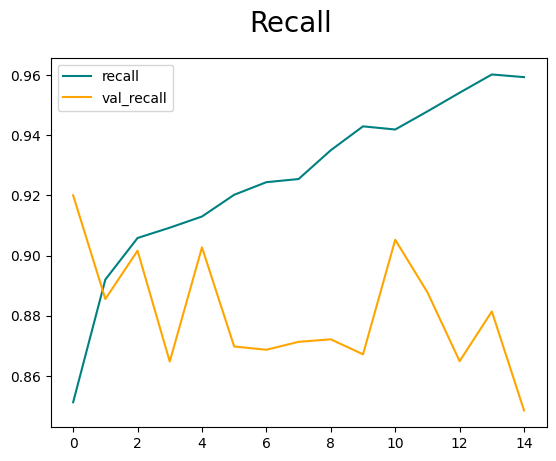

In [52]:
fig = plt.figure()
plt.plot(history_inception.history['recall_1'], color='teal', label='recall')
plt.plot(history_inception.history['val_recall_1'], color='orange', label='val_recall')
fig.suptitle('Recall', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [3]:
# MODEL EVALUATION ON TEST DATASET - LOADING SAVED MODEL


def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

# Add custom F1-score metric
def f1_metric(y_true, y_pred):
    return f1_score(y_true, y_pred)


m1 = load_model('Models/Mel_Class_Model_With_simple_aug_1.h5', custom_objects={'f1_metric': f1_metric})
m0 = load_model('Models/Mel_Class_Model_With_ext_data_class_w_No_aug_0.h5', custom_objects={'f1_metric': f1_metric})
m2 = load_model('Models/Mel_Class_Inception_Model.h5', custom_objects={'f1_metric': f1_metric})
models = [m0,m1,m2]


In [12]:

# MODEL 1:  CNN model with External Data without Data Augmentation
i=0
pre0 = Precision()
re0 = Recall()
acc0 = BinaryAccuracy()

for batch in test.as_numpy_iterator(): 
    if i == 5 :
        break
    else:
        X, y = batch
        yhat = m0.predict(X)
        pre0.update_state(y, yhat)
        re0.update_state(y, yhat)
        acc0.update_state(y, yhat)
    i=i+1
print('Precision for CNN model with External Data - without Data Augmentation :',pre0.result().numpy())
print('Recall for CNN model with External Data - without Data Augmentation :', re0.result().numpy())
print('Accuracy for CNN with External Data - without Data Augmentation :',acc0.result().numpy())

1/1 [==============================] - 0s 138ms/step
Precision for CNN model with External Data - without Data Augmentation : 0.93333334
Recall for CNN model with External Data - without Data Augmentation : 0.9655172
Accuracy for CNN with External Data - without Data Augmentation : 0.98125


In [13]:
# MODEL 2:  DCNN model with External Data and Data Augmentation
i=0
pre1 = Precision()
re1 = Recall()
acc1 = BinaryAccuracy()

for batch in test.as_numpy_iterator(): 
    if i == 5 :
        break
    else:
        X, y = batch
        yhat = m1.predict(X)
        pre1.update_state(y, yhat)
        re1.update_state(y, yhat)
        acc1.update_state(y, yhat)
    i=i+1
print('Precision for CNN model with External Data - with Data Augmentation :',pre1.result().numpy())
print('Recall for CNN model with External Data - with Data Augmentation :', re1.result().numpy())
print('Accuracy for CNN with External Data - with Data Augmentation :',acc1.result().numpy())

1/1 [==============================] - 0s 101ms/step
Precision for CNN model with External Data - with Data Augmentation : 0.88235295
Recall for CNN model with External Data - with Data Augmentation : 0.71428573
Accuracy for CNN with External Data - with Data Augmentation : 0.95


In [14]:
# MODEL 3:  Transfer learning model with External Data without Data Augmentation
i=0
pre2 = Precision()
re2 = Recall()
acc2 = BinaryAccuracy()

for batch in test.as_numpy_iterator(): 
    if i == 5 :
        break
    else:
        X, y = batch
        yhat = m2.predict(X)

        pre2.update_state(y, yhat)
        re2.update_state(y, yhat)
        acc2.update_state(y, yhat)
    i=i+1
print('Precision for Inception Model with External - without Data Augmentation :',pre2.result().numpy())
print('Recall for Inception model with External Data - without Data Augmentation :', re2.result().numpy())
print('Accuracy for Inception with External model Data - without Data Augmentation :',acc2.result().numpy())

1/1 [==============================] - 0s 444ms/step
Precision for Inception Model with External - without Data Augmentation : 0.94736844
Recall for Inception model with External Data - without Data Augmentation : 0.94736844
Accuracy for Inception with External model Data - without Data Augmentation : 0.9875
